<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/003_udacity_self_driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# What GPU do we have ?
!nvidia-smi

Mon Oct 12 06:21:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [3]:
# Clone the RetinaNet Repo
!git clone https://github.com/benihime91/pytorch_retinanet.git
# install dependencies
!pip install pytorch-lightning omegaconf wandb --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet
!echo "[   OK   ] Installed all depedencies "

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1956 (delta 126), reused 114 (delta 47), pack-reused 1730
Receiving objects: 100% (1956/1956), 69.07 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (1290/1290), done.
     |████████████████████████████████| 481kB 4.5MB/s 
     |████████████████████████████████| 1.7MB 11.3MB/s 
     |████████████████████████████████| 829kB 30.1MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 276kB 31.7MB/s 
     |████████████████████████████████| 163kB 32.0MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 122kB 30.4MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 952kB 4.9MB/s 
[   OK   ] Installed all depeden

In [4]:
#Update sys path to enclude the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

!echo "[   OK   ] Setup Done "

[   OK   ] Setup Done 


In [5]:
#Downloading data Udacity-self driving dataset from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
#https://public.roboflow.com/object-detection/self-driving-car
%cd /content
!curl -L "https://public.roboflow.com/ds/C3CTTjCelU?key=G3KeQPl4TO" > roboflow.zip
!unzip -qq roboflow.zip
!rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1246      0 --:--:-- --:--:-- --:--:--  1246
100 3152M  100 3152M    0     0  59.4M      0  0:00:53  0:00:53 --:--:-- 38.4M


In [6]:
#Set up paths 

#Path to where the Images are stored
IMAGE_PATH = "/content/export"
#Path where annotations are stored
ANNOT_PATH = "/content/export"

In [7]:
import pandas as pd
from utils.pascal import convert_annotations_to_df
from PIL import Image
import cv2
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", None)
np.random.seed(123)


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

def split_dataframe(dataframe, split_size:float=0.3, seed=123):
    """
    Splits a given pandas DataFrame object in `split_size`
    
    Args:
        dataframe: a pandas DataFrame object
        split_size: fraction size of the test dataframe
        seed : a random seed to ensure reproducibility
    
    Returns :
        1. train_df: a pandas DataFrame of size `(1-split_size)*len(dataframe)`
        2. test_df : a pandas DataFrame of size `(split_size)*len(dataframe)`
    """
    unique_ids = list(dataframe.filename.unique())
    train_ids, test_ids = train_test_split(unique_ids, 
                                           shuffle=True, 
                                           random_state=seed, 
                                           test_size=split_size
                                           )
    
    dataframe["split"] = 0
    
    for i,idx in enumerate(tqdm(dataframe.filename.values)):
        if idx in set(train_ids): 
            dataframe["split"][i] = "train"
        
        elif idx in set(test_ids) : 
            dataframe["split"][i] = "test"

    #Create the training and test dataframes
    df_train = dataframe.loc[dataframe["split"] == "train"]
    df_test = dataframe.loc[dataframe["split"] == "test"]
    #Reset indices and drop the redundant "split" column
    df_train, df_test = df_train.reset_index(drop=True),df_test.reset_index(drop=True)
    df_train.drop(columns=["split"], inplace=True)
    df_test.drop(columns=["split"], inplace=True)

    return df_train, df_test

In [9]:
#Create a pandas dataframe object from the xml files and filter the invalid annotations
dataframe = remove_invalid_annots(convert_annotations_to_df(ANNOT_PATH, IMAGE_PATH, image_set="train"))
dataframe.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg,1920,1200,car,86,552,328,714,2
1,/content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg,1920,1200,car,110,556,314,690,2
2,/content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg,1920,1200,car,306,584,436,660,2
3,/content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg,1920,1200,car,320,574,426,674,2
4,/content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg,1920,1200,car,434,578,550,658,2


In [10]:
#Create train and test datasets
train_df, test_df = split_dataframe(dataframe=dataframe, split_size=0.3)
print("Num Training examples: ", len(train_df.filename.unique()), end="\n\n")

#Create test and validation datasets
valid_df, test_df = split_dataframe(dataframe=test_df, split_size=0.5)
print("Num Training examples: ", len(test_df.filename.unique()))
print("Num Validation examples:", len(valid_df.filename.unique()))


Num Training examples:  9267




Num Training examples:  1986
Num Validation examples: 1986


In [11]:
#save dataframes to memory
TRAIN_PATH = "/content/train_data.csv"
TEST_PATH = "/content/test_data.csv"
VALIDATION_PATH = "/content/validation_data.csv"


train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)
valid_df.to_csv(VALIDATION_PATH, index=False)

In [12]:
from utils.pascal import generate_pascal_category_names
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt

#Generate a lable map for categories
LABEL_MAP = generate_pascal_category_names(dataframe)
print(LABEL_MAP)


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index
    """
    assert index <= len(dataframe), f"[  ERROR  ] Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

['__background__', 'biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


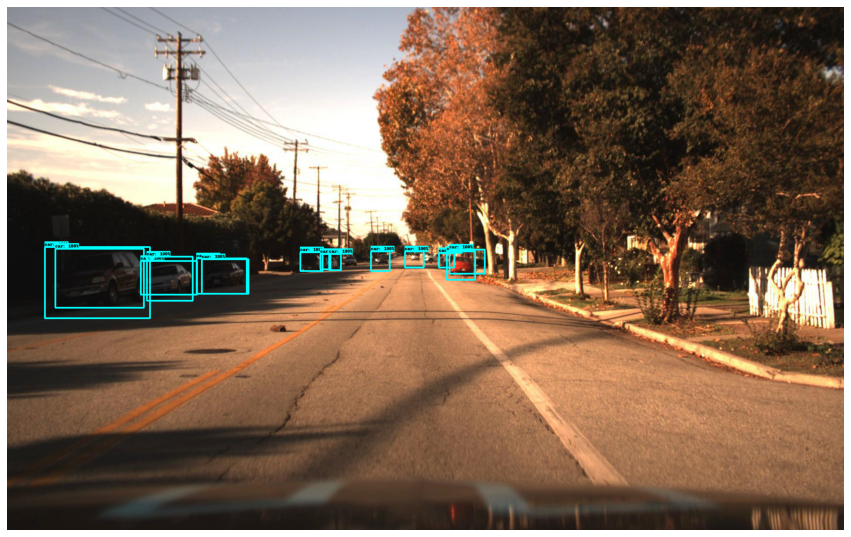

In [13]:
image = load_image_from_data(train_df, index=10)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis("off")
plt.show();

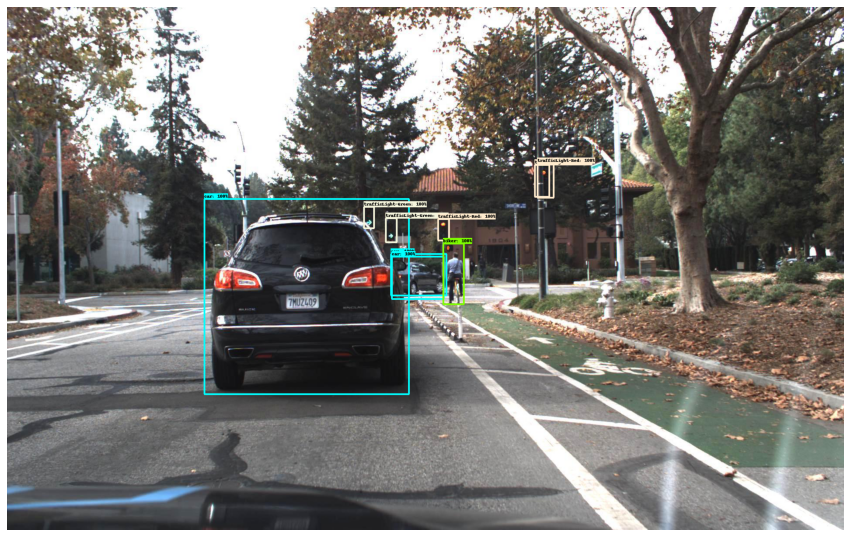

In [14]:
image = load_image_from_data(test_df, index=100)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis("off")
plt.show();

In [15]:
from omegaconf import OmegaConf

hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

hparams.dataset.kind = "csv"

hparams.dataset.trn_paths   = TRAIN_PATH
hparams.dataset.valid_paths = VALIDATION_PATH
hparams.dataset.test_paths  = TEST_PATH
hparams.model.num_classes = len(LABEL_MAP) - 1

hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params": {
        "lr": 0.003,
        "momentum": 0.9,
        "weight_decay" : 0.001,
        },
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet50
  num_classes: 11
  freeze_bn: true
  min_size: 800
  max_size: 1600
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/validation_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 2
  valid_bs: 30
  test_bs: 30
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.003
    momentum: 0.9
    weight_decay: 0.001
scheduler:
  class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
  params:
    mode: min
    factor: 0.1
    patience: 5
    verbose: true
  interval: epoch
  frequency: 1
  monitor: val_loss



In [16]:
import time
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import *
from pytorch_lightning.callbacks import *
from model import RetinaNetModel, LogCallback

# seed so that results are reproducible
pl.seed_everything(123)

123

In [17]:
#Logger
#wandb API-KEY
!wandb login "a74f67fd5fae293e301ea8b6710ee0241f595a63"
#Wandb project name
PNAME = "pytorch_retina"
LOGGER = WandbLogger(name=f"{time.time()}", anonymous=True, project=PNAME)

#Learning-rate Logger to log the learning-rate to the logger
LR_LOGGER = LearningRateLogger(logging_interval="step")

#Model Checkpoint Callback, this callback will save checkpoints 
#each time our val loss decreases
fname =f"/content/checkpoints/"
os.makedirs(fname, exist_ok=True)
CHECKPOINT_CALLBACK = ModelCheckpoint(fname, mode="min", monitor="val_loss", save_top_k=3,)

#callback for early-stopping
EARLY_STOPPING_CALLBACK = EarlyStopping(mode="min", monitor="val_loss", patience=12, verbose=True)

#instantiate LightningTrainer
trainer = Trainer(
    precision=16, 
    max_epochs=100,
    gpus=1, 
    logger=[LOGGER],
    early_stop_callback=EARLY_STOPPING_CALLBACK, 
    checkpoint_callback=CHECKPOINT_CALLBACK,
    callbacks=[LogCallback(), LR_LOGGER], 
    weights_summary=None,
    terminate_on_nan=True, 
    benchmark=True,
    );

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


GPU available: True, used: True
[10/12 06:29:13] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[10/12 06:29:13] lightning INFO: TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[10/12 06:29:13] lightning INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[10/12 06:29:13] lightning INFO: Using native 16bit precision.


In [ ]:
#Instantiate lightning-module
litModel = RetinaNetModel(hparams=hparams)
#Start Train
trainer.fit(litModel)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



[10/12 06:29:23 retinanet.models]: BACKBONE : resnet50
[10/12 06:29:23 retinanet.models]: INPUT PARAMS : MAX_SIZE=1600, MIN_SIZE=800
[10/12 06:29:23 retinanet.models]: NUM CLASSES : 11
[10/12 06:29:24 retinanet.models]: DATASET_KIND : csv
[10/12 06:29:33 retinanet.models]: OPTIMIZER_NAME : SGD
[10/12 06:29:33 retinanet.models]: LEARNING_RATE: 0.003
[10/12 06:29:33 retinanet.models]: WEIGHT_DECAY: 0.001
[10/12 06:29:33 retinanet.models]: LR_SCHEDULER_NAME : ReduceLROnPlateau
[10/12 06:29:33 retinanet.models]: MAX_EPOCHS : 100


[10/12 06:29:34] wandb INFO: setting login settings: {'anonymous': 'allow'}
wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)


[10/12 06:29:47 retinanet.models]: Training on 9267 images
[10/12 06:29:47 retinanet.models]: Training from iteration 0 : 


In [ ]:
# Evaluations results on the test/ validation dataset(if test dataset is not given)
# using COCO API
trainer.test()

In [ ]:
import torch
from retinanet import Retinanet

PATH = f"/content/trained_weights.pth"
torch.save(litModel.model.state_dict(), PATH)

state_dict = torch.load(PATH)
MODEL = Retinanet(num_classes=hparams.model.num_classes, backbone_kind=hparams.model.backbone_kind)
MODEL.load_state_dict(state_dict)
MODEL.to("cuda:0");

In [ ]:
from PIL import Image
import numpy as np
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import visualize_boxes_and_labels_on_image_array

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([A.ToFloat(max_value=255.0, always_apply=True),
                                  ToTensorV2(always_apply=True)
                                  ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS = MODEL.predict([TENSOR_IMAGE])
    #print(PREDICTIONS[0])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Args:
        image_path: Path to the input Image
        threshold: Score threshold to filter predictions
        nms_threshold: NMS threshold

    Returns: a PIL image containg the original Image and
             bounding boxes draw over it.
    """
    
    # visualize_boxes_and_labels_on_image_array function
    # expects the pixels values of the image to be in 
    # range [0,1] so be divide the loaded image by 255.0
    # to noramlize the co-ordinates
    # load the image as numpy array
    image = Image.open(image_path)
    image = np.array(image) / 255.
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask = scores > threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()